In [1]:
import pandas as pd
import os
import base64
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#key = os.environ['Toggl']
key = 'a133b5e31d5555a386bc2166e7d84a78'

string=key+':api_token'
headers={
    'Authorization':'Basic '+base64.b64encode(string.encode('ascii')).decode('utf-8'),
    "Content-Type": "application/json"   
}

proxies = {
    'http' : os.environ['http_proxy'],
    'https' : os.environ['https_proxy']
}

params = {
    'since':'2021-01-01',
    'until':'2021-12-31',
    'user_agent': 'm2edney@gmail.com',
    'workspace_id' : "3112792"
}

response = requests.get('https://api.track.toggl.com/reports/api/v2/details', headers = headers, params= params, proxies = proxies)
my_json = json.loads(response.content)
df = pd.DataFrame(my_json['data'])

In [2]:
page_count = int(my_json['total_count']/my_json['per_page']) + (my_json['total_count'] % my_json['per_page'] > 0)
for page in range(1, page_count):
    params['page']= str(page)
    response = requests.get('https://api.track.toggl.com/reports/api/v2/details', headers = headers, params= params)
    my_json = json.loads(response.content)
    df =pd.concat([df, pd.DataFrame(my_json['data'])])
    
df['dur'] = df['dur']/1000/60/60
df = df[~df['project'].isnull()]
df = df.drop(['tid','updated', 'user', 'use_stop', 'client', 'project_color', 'project_hex_color', 'task', 'billable', 'is_billable', 'cur'],
            axis = 1)

df['Month'] = pd.to_datetime(df['start'], utc=True).dt.month_name()
df= df.sort_values('start')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Walmart'),
  Text(1, 0, 'Commute'),
  Text(2, 0, 'Data Science Study'),
  Text(3, 0, 'Article'),
  Text(4, 0, 'Job Seeking'),
  Text(5, 0, 'ocwa')])

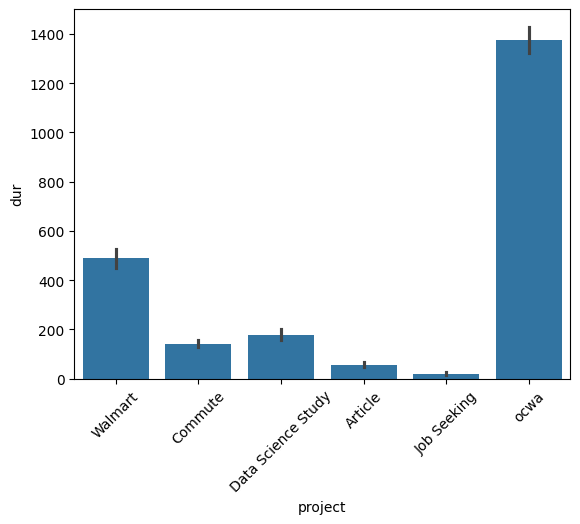

In [3]:
sns.barplot(x='project', y= 'dur', data = df, estimator = 'sum')
plt.xticks(rotation=45)

## Dashboard Section

In [4]:
# Import packages
from dash import Dash, html, dash_table, dcc, callback, Output, Input, jupyter_dash
import pandas as pd
import plotly.express as px

jupyter_dash.default_mode="external"

# Initialize the app
app = Dash(__name__)

df2= df.groupby(['Month', 'project']).sum().reset_index().sort_values('start')

# App layout
app.layout = html.Div([
    dcc.Tabs(id="tabs", value='tab-1', children=[
        dcc.Tab(label='Data Table', value='tab-1'),
        dcc.Tab(label='Annual Review', value='tab-2', children=[
            dcc.RadioItems(options=['avg', 'count', 'sum'], value='sum', id='controls-and-radio-item')]),
        dcc.Tab(label='Monthly Review', value='tab-3'),
    ]),
    html.Div(id='tabs-content')
])

@callback(
    Output('tabs-content', 'children'),
    Input('tabs', 'value'),
    Input('controls-and-radio-item', 'value')
)

def render_content(tab, hist):
    if tab == 'tab-1':
        return html.Div([
            dash_table.DataTable(data=df.drop('tags', axis = 1).to_dict('records'), page_size=10)
        ])
    elif tab == 'tab-2':
        return html.Div([
            dcc.Graph(figure = px.histogram(df, x='project', y='dur', color = 'description', histfunc = hist),
                     id='controls-and-graph')   
        ])
    elif tab == 'tab-3':
        return html.Div([
            dcc.Graph(figure = px.line(df2, y = 'dur', x = 'Month', color = 'project', markers=True))          
        ])

# Run the app
if __name__ == '__main__':
    app.run(debug=True)


Exception: <HTML><HEAD>
<TITLE>Network Error</TITLE>
</HEAD>
<BODY>
<FONT face="Helvetica">
<big><strong></strong></big><BR>
</FONT>
<blockquote>
<TABLE border=0 cellPadding=1 width="80%">
<TR><TD>
<FONT face="Helvetica">
<big>Network Error (tcp_error)</big>
<BR>
<BR>
</FONT>
</TD></TR>
<TR><TD>
<FONT face="Helvetica">
A communication error occurred: "Connection refused"
</FONT>
</TD></TR>
<TR><TD>
<FONT face="Helvetica">
The Web Server may be down, too busy, or experiencing other problems preventing it from responding to requests. You may wish to try again at a later time or contact the Web Site administrator directly.
</FONT>
</TD></TR>
<TR><TD>
<FONT face="Helvetica" SIZE=2>
<BR>
For assistance, <a href='mailto:TechService@toronto.ca'>email TSD Service Desk</a> or call 416-338-2255
</FONT>
</TD></TR>
</TABLE>
</blockquote>
</FONT>
</BODY></HTML>


In [ ]:
sns.lineplot(data = df, y= 'dur', x= 'Month', hue= 'project', sort=False, estimator= sum, errorbar = None)
plt.xticks(rotation=45)

In [ ]:
df.groupby(['Month', 'project']).sum().reset_index().sort_values('start')